In [1]:
import pandas as pd 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Loading data

In [15]:
df_pos = pd.read_excel('data/output/clean_handlabeled_data.xlsx')
df_neg = pd.read_excel('data/output/clean_handlabeled_data.xlsx')
df_pos_vader = pd.read_excel('data/output/clean_handlabeled_data.xlsx')
df_neg_vader = pd.read_excel('data/output/clean_handlabeled_data.xlsx')

## Preparing data for calculations

In [18]:
def not_null_and_mapping(df, map_to, df_type):
    
    if df_type == 'vader':
        df = df[pd.notnull(df['COMMENT'])]
        df = df[pd.notnull(df['LABEL'])]
        return df

    elif df_type == 'hl':
    
        if map_to == 'POS':
            df['LABEL'] = df['LABEL'].map({'NEU':'POS','POS':'POS','NEG':'NEG'})
        elif map_to == 'NEG':
            df['LABEL'] = df['LABEL'].map({'NEU':'NEG','POS':'POS','NEG':'NEG'})
            
        df['TRUE_LABEL'] = df['LABEL'].map({'POS':1,'NEG':0})
        #df['TRUE_LABEL'] = df['TRUE_LABEL'].astype('int64')
        
        
        return df
        

In [19]:
df_pos = not_null_and_mapping(df_pos, 'POS','hl')
df_neg = not_null_and_mapping(df_neg, 'NEG','hl')
df_pos_vader = not_null_and_mapping(df_pos_vader, 'POS','vader')
df_neg_vader = not_null_and_mapping(df_neg_vader, 'NEG','vader')

In [20]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 998
Data columns (total 3 columns):
COMMENT       974 non-null object
LABEL         974 non-null object
TRUE_LABEL    974 non-null int64
dtypes: int64(1), object(2)
memory usage: 30.4+ KB


In [42]:
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 998
Data columns (total 3 columns):
COMMENT       974 non-null object
LABEL         974 non-null object
TRUE_LABEL    974 non-null int64
dtypes: int64(1), object(2)
memory usage: 30.4+ KB


## Assigning VADER labels

In [45]:
def get_compound_score(comment):
    ss = sid.polarity_scores(str(comment))
    return ss['compound']

def get_sentiment(compound_score):
    if compound_score >= 0:
        return 1
    else:
        return 0


def vader(df):
    for comment in df.COMMENT:
        ss = sid.polarity_scores(comment)
    
    df['compound_score'] = df['COMMENT'].apply(lambda x: get_compound_score(x))
    df['PRED_LABEL'] = df['compound_score'].apply(lambda x: get_sentiment(x))
    
    return df

In [46]:
df_pos_vader = vader(df_pos_vader)

In [47]:
df_pos_vader.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 998
Data columns (total 4 columns):
COMMENT           974 non-null object
LABEL             974 non-null object
compound_score    974 non-null float64
PRED_LABEL        974 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 38.0+ KB


In [48]:
df_neg_vader = vader(df_neg_vader)

In [49]:
df_neg_vader['PRED_LABEL'].value_counts()

1    739
0    235
Name: PRED_LABEL, dtype: int64

## Joining vader labels and true labels on index

In [28]:
'''result_pos = pd.merge(df_pos_vader[['COMMENT','PRED_LABEL']], 
                      df_pos[['TRUE_LABEL']], 
                      left_index=True, 
                      right_index=True, 
                      how="inner")'''

'result_pos = pd.merge(df_pos_vader[[\'COMMENT\',\'PRED_LABEL\']], \n                      df_pos[[\'TRUE_LABEL\']], \n                      left_index=True, \n                      right_index=True, \n                      how="inner")'

In [29]:
'''result_neg = pd.merge(df_neg_vader[['COMMENT','PRED_LABEL']], 
                      df_neg[['TRUE_LABEL']], 
                      left_index=True, 
                      right_index=True, 
                      how="inner")'''

'result_neg = pd.merge(df_neg_vader[[\'COMMENT\',\'PRED_LABEL\']], \n                      df_neg[[\'TRUE_LABEL\']], \n                      left_index=True, \n                      right_index=True, \n                      how="inner")'

## Calculating F1 Score for NEU mapped to POS and NEG, respectively 

In [30]:
from sklearn.metrics import f1_score
y_true_pos = df_pos['TRUE_LABEL']
y_pred_pos = df_pos_vader['PRED_LABEL']


f1_score(y_true_pos, y_pred_pos, average='weighted') 

0.5084140831155031

In [33]:
from sklearn.metrics import f1_score
y_true_neg = df_neg['TRUE_LABEL']
y_pred_neg = df_neg_vader['PRED_LABEL']




f1_score(y_true_neg, y_pred_neg, average='weighted') 

0.6347994135826863

In [34]:
y_true_neg.value_counts()

0    713
1    261
Name: TRUE_LABEL, dtype: int64

Vader is better at predicting our labels when we map neutral to negative. 

This being said, VADER is predicting more negative than positive when looking at our comments. 

In [35]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [36]:
y_true_neg = y_true_neg.astype('int64')
y_true_pos = y_true_pos.astype('int64')

classes = np.array([0,1])
classes

array([0, 1])

Confusion matrix, without normalization
[[485 228]
 [142 119]]


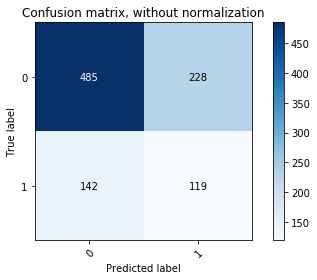

In [37]:
plot_confusion_matrix(y_true_neg, y_pred_neg,classes)

Confusion matrix, without normalization
[[270 117]
 [357 230]]


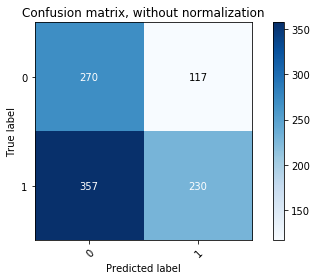

In [38]:
plot_confusion_matrix(y_true_pos, y_pred_pos,classes)

Confusion matrix, without normalization
[[140 247]
 [ 95 492]]


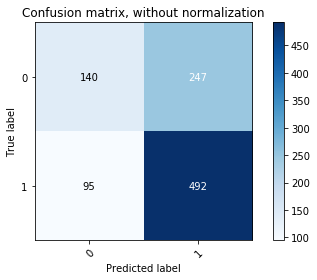

In [50]:
plot_confusion_matrix(y_true_pos, y_pred_pos,classes)